In [71]:
import os
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

#modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn_pandas import DataFrameMapper
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

In [72]:
pwd

'C:\\Users\\Sam Cannon\\Desktop\\Python\\Springboard\\Data Science Career Track\\Capstone 1\\seattle_police'

In [4]:
os.chdir('C:\\Users\\Sam Cannon\\Desktop\\Python\\Springboard\\Data Science Career Track\\Capstone 1\\seattle_police')

In [7]:
#read in data, attempt to parse the call time date features
df = pd.read_csv('Call_Data.csv', parse_dates = [6, 7])

In [73]:
#look at some descriptive info for our dataset, looks like the date parser was unable to parse arrived_time, so I will parse that next
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4170107 entries, 0 to 2085053
Data columns (total 11 columns):
cad_event_number               int64
event_clearance_description    object
call_type                      object
priority                       int64
initial_call_type              object
final_call_type                object
original_time_queued           datetime64[ns]
arrived_time                   datetime64[ns]
precinct                       object
sector                         object
beat                           object
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 381.8+ MB


In [9]:
#create datetime object from arrived time
df['Arrived Time'] = [datetime.strptime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['Arrived Time']]

In [74]:
#now I want to lowercase the entire dataframe so that there arent any capitalization error issues
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

In [75]:
#now I want to lowercase the columns and replace spaces withn _
df.columns = [c.lower() for c in df.columns]
df.columns = [c.replace(' ', '_') for c in df.columns]

In [76]:
#now I want to look at the head of my data to make sure the changes look right
df.head(1)

,cad_event_number,event_clearance_description,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat
0,2009000189335,evidence submitted (new incident number required),"telephone other, not 911",1,dist - ip/jo - dv dist - no aslt,"--dv - arguments, disturbance (no arrest)",2009-06-02 03:35:46,2009-06-02 04:09:38,east,charlie,c1


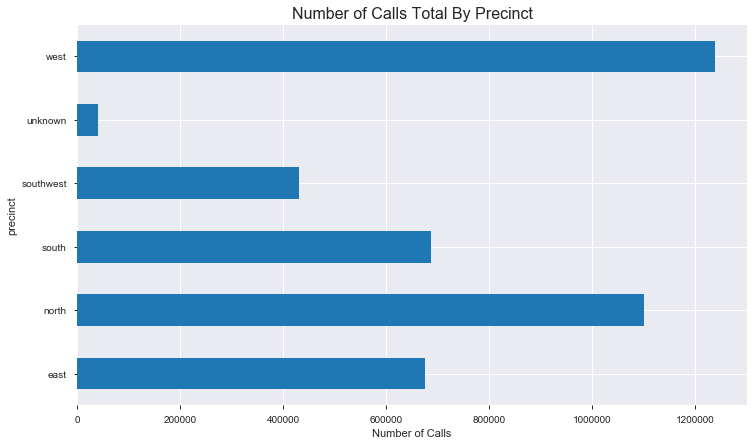

In [18]:
#how many calls are each precinct receiving in total?
df.groupby('precinct').cad_event_number.size().plot(kind = 'barh', figsize = (12, 7))
plt.title('Number of Calls Total By Precinct', fontsize = 16)
plt.xlabel('Number of Calls');

In [77]:
#I want to start with the precinct that had the most calls, so I will only be looking at data from the West precinct first
west = df[df['precinct'] == 'west']

#how much data do we have in this df?
west.shape

(1238467, 11)

In [78]:
#how many sectors and beats are in this precinct?
west.groupby(['sector', 'beat']).size()

sector  beat
david   d1      103990
        d2      116647
        d3       88081
king    k1       98693
        k2      112106
        k3      142091
mary    inv          1
        m1      103760
        m2      103996
        m3      143499
queen   q1       52862
        q2       76240
        q3       96501
dtype: int64

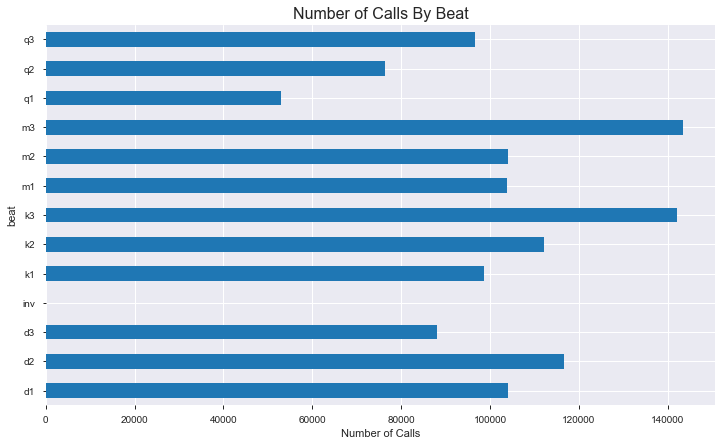

In [28]:
#plot this out to make it more interpretatble
west.groupby('beat').size().plot(kind = 'barh', figsize = (12, 7))
plt.title('Number of Calls By Beat', fontsize = 16)
plt.xlabel('Number of Calls');

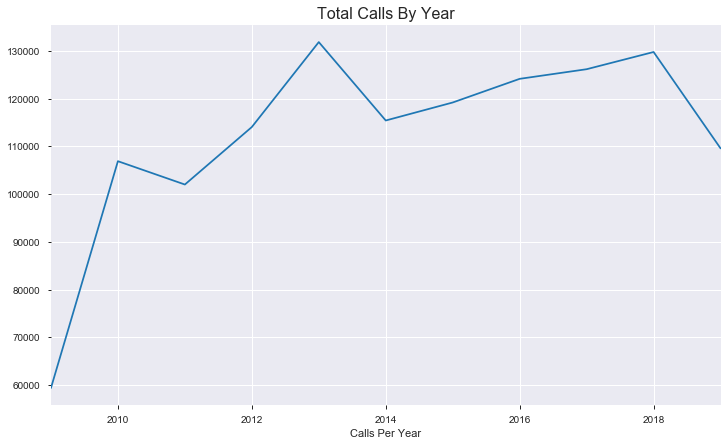

In [40]:
#looks like overall, the m3 and k3 beats have the most crimes being reported, what does call volume look like over time?
west.groupby(west['original_time_queued'].dt.year).size().plot(figsize = (12, 7))
plt.title('Total Calls By Year', fontsize = 16)
plt.xlabel('Calls Per Year');

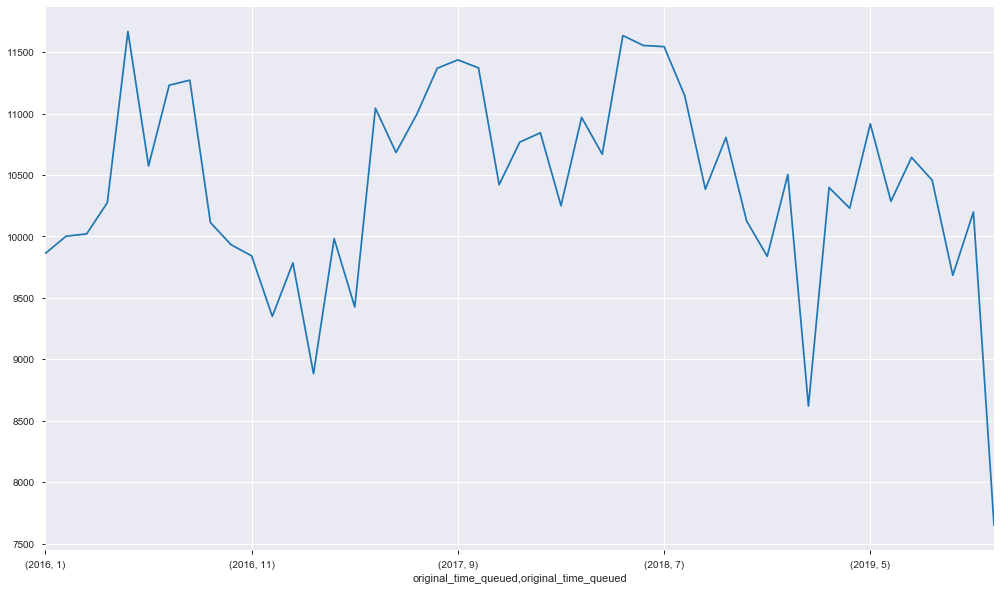

In [58]:
west[west['original_time_queued'].dt.year > 2015].groupby([west['original_time_queued'].dt.year, west['original_time_queued'].dt.month]).size().plot(figsize = (17, 10));

In [105]:
west.shape

(1238468, 11)

In [106]:
west.head()

,cad_event_number,event_clearance_description,call_type,priority,initial_call_type,final_call_type,arrived_time,precinct,sector,beat,number_of_calls
original_time_queued,,,,,,,,,,,
2015-07-11 22:54:07,2015000237932,report written (no arrest),onview,2,fight - jo - physical (no weapons),--disturbance - fight,2015-07-11 22:54:07,west,david,d1,1
2014-05-21 11:51:18,2014000158829,oral warning given,"telephone other, not 911",3,parking violation (except abandoned car),--traffic - parking viol (except abandoned car),1900-01-01 00:00:00,west,queen,q2,1
2015-07-11 22:54:28,2015000237933,report written (no arrest),onview,3,"mvc - report, non inj/non blkg or after fact inj",--traffic - mv collision investigation,2015-07-11 22:54:28,west,david,d2,1
2014-05-21 11:50:20,2014000158828,assistance rendered,onview,3,follow up,--disturbance - other,2014-05-21 11:50:20,west,king,k3,1
2015-07-11 22:47:26,2015000237922,assistance rendered,onview,7,"premise check, officer initiated onview only",--premise checks - crime prevention,2015-07-11 22:47:26,west,david,d1,1


In [108]:
west.beat.unique()

array(['d1', 'q2', 'd2', 'k3', 'k2', 'm2', 'q1', 'k1', 'm3', 'm1', 'd3',
       'q3', 'inv', 1], dtype=object)

## NoW I want to model for each individual beat within the West Precinct, starting with d1

In [112]:
#subset west df, drop unnecessary columns
d1 = west[west['beat'] == 'd1'].drop(['precinct', 'sector'], axis = 1)

In [114]:
#set index to datetime
d1.set_index('original_time_queued', inplace = True).head()

,cad_event_number,event_clearance_description,call_type,priority,initial_call_type,final_call_type,arrived_time,beat,number_of_calls
original_time_queued,,,,,,,,,
2015-07-11 22:54:07,2015000237932,report written (no arrest),onview,2,fight - jo - physical (no weapons),--disturbance - fight,2015-07-11 22:54:07,d1,1
2015-07-11 22:47:26,2015000237922,assistance rendered,onview,7,"premise check, officer initiated onview only",--premise checks - crime prevention,2015-07-11 22:47:26,d1,1
2014-05-21 11:32:10,2014000158799,report written (no arrest),911,2,"mvc - non injury, blocking",--traffic - mv collision investigation,2014-05-21 12:15:29,d1,1
2014-05-21 10:57:13,2014000158772,other report made,onview,7,traffic stop - officer initiated onview,--traffic - moving violation,2014-05-21 10:57:13,d1,1
2015-07-12 00:32:44,2015000238052,report written (no arrest),onview,3,"disturbance, miscellaneous/other",--disturbance - fight,2015-07-12 00:32:44,d1,1


In [122]:
#resample df for rollup of daily call volume
d1_daily_calls = pd.DataFrame(d1.cad_event_number.resample('d').size())
d1_daily_calls.rename(columns = {'cad_event_number':'daily_calls'}, inplace = True)
d1_daily_calls.head()

,daily_calls
original_time_queued,
2009-06-02,37
2009-06-03,33
2009-06-04,37
2009-06-05,30
2009-06-06,37


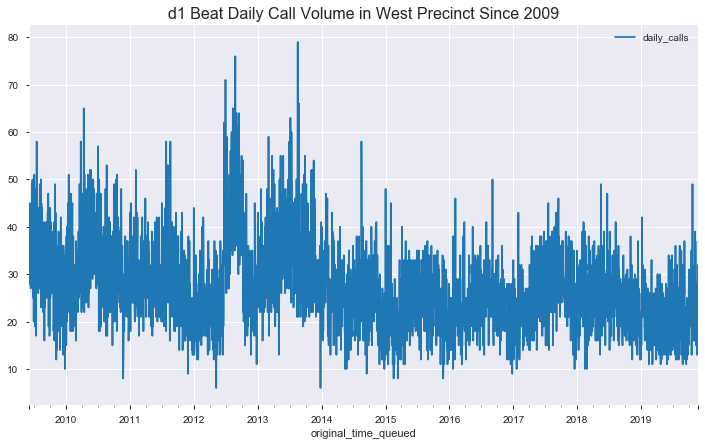

In [130]:
#plot out daily calls for d1 beat in west precinct, looks like the daily calls have been trending down overall, with a spike in 2012
d1_daily_calls.plot(figsize = (12, 7))
plt.title('d1 Beat Daily Call Volume in West Precinct Since 2009', fontsize = 16);

__Rolling Means__
- Now I want to look at plotting the data vs a "rolling mean", which is just the average of whatever window size that you specify
- I am going to play around with several different window sizes to find a good fit for the data

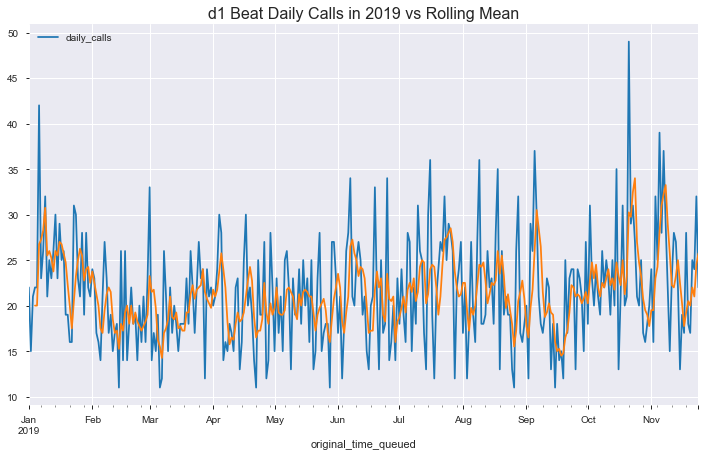

In [155]:
#now look at only data for 2019
d1_2019 = d1_daily_calls.loc['2019-01-01':, :]

#now plot that data against a rolling mean with a window size of 
d1_2019.plot(figsize = (12, 7))
plt.title('d1 Beat Daily Calls in 2019 vs Rolling Mean', fontsize = 16)

#we can make the window ANY size
d1_2019.rolling(window = 4).mean()['daily_calls'].plot();

__Outlier Removal__
- Removing outliers can increase the quality of a model's predictions significantly, so I will do this and plot the rolling mean again as well

In [157]:
d1_2019.head()

,daily_calls
original_time_queued,
2019-01-01,22
2019-01-02,15
2019-01-03,21
2019-01-04,22
2019-01-05,22


In [161]:
def z_score_indices_of_outliers(X, threshold=3):
    '''
    Detects outliers using Z-score standardization
    
    Input: - X: A feature in your dataset
           - threshold: The number of standard deviations from the mean
                        to be considered an outlier
                        
    Output: A data frame with all outliers beyond 3 standard deviations
    '''
    X_mean = np.mean(X)
    X_stdev = np.std(X)
    z_scores = [(y - X_mean) / X_stdev for y in X]
    z_df = pd.DataFrame(z_scores)
    pos_outliers = z_df[z_df[0] > 3]
    neg_outliers = z_df[z_df[0] < -3]
    return pos_outliers; neg_outliers

In [177]:
#detect outliers
to_drop = z_score_indices_of_outliers(d1_2019['daily_calls'])

#remove outliers 
d1_2019 = d1_2019.reset_index().drop(to_drop.index).set_index('original_time_queued')

#ensure that it worked (the 6th should be missing)
d1_2019.head(6)

,daily_calls
original_time_queued,
2019-01-01,22
2019-01-02,15
2019-01-03,21
2019-01-04,22
2019-01-05,22
2019-01-07,23


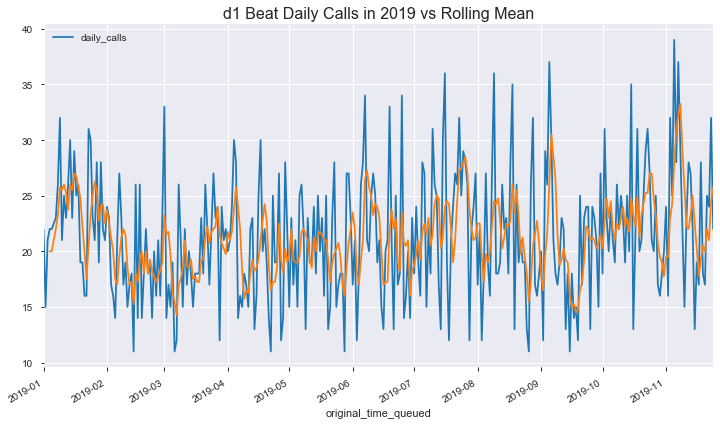

In [178]:
#now plot that data against a rolling mean with a window size of 4 days
d1_2019.plot(figsize = (12, 7))
plt.title('d1 Beat Daily Calls in 2019 vs Rolling Mean', fontsize = 16)

#plot rolling mean, we can see that the rolling mean fits the data a little better than it did with the outliers in place
d1_2019.rolling(window = 4).mean()['daily_calls'].plot();

__Finding Overall Trends__
- I am going to use the hodrick-prescott filter to find the overall trend for this beat's call volume
- you can set the filter for windows of data, I am going to use quarterly (by setting lambda value)

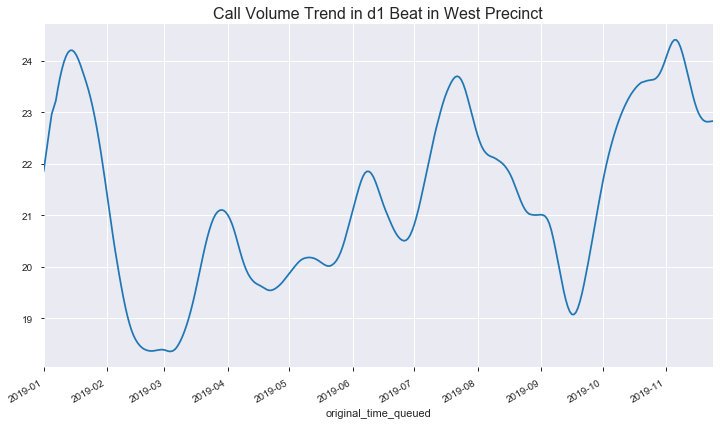

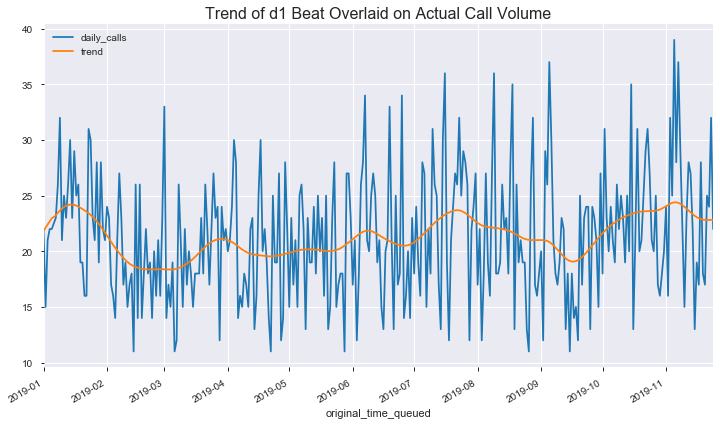

In [190]:
#use statsmodels to get the trend (hodrick-prescott filter)
from statsmodels.tsa.filters.hp_filter import hpfilter

# tuple unpacking gdp_cycle, gdp_trend
call_cycle, call_trend = hpfilter(d1_2019.daily_calls, lamb = 1600)

call_trend.plot(figsize = (12, 7))
plt.title('Call Volume Trend in d1 Beat in West Precinct', fontsize = 16)

#add trend column to d1_2019 so that we can plot the trend on top of the df
d1_2019['trend'] = call_trend

#plot the trend over the data
d1_2019[['daily_calls', 'trend']].plot(figsize = (12, 7))
plt.title('Trend of d1 Beat Overlaid on Actual Call Volume', fontsize = 16);